# PCBO: Preferential Causal Bayesian Optimisation


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom modules
from flows import real_nvp, create_base_distribution
from prefflow import PrefFlow
from pcbo_dataset import PCBO_Dataset_Three
from parent_posterior import ParentPosterior
from acquisition import pig_pairwise, eeig_pairwise
from dag_visual import plot_dag

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device and precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision_double = True
print(f"Using device: {device}")

Using device: cpu


## Problem Setup

In [2]:
"""
Toy Problem: X1 -> Y <- X2
- We can intervene on X1, X2, or Y
- True utility: minimize |Y| with small intervention cost
- Learn both the causal graph and utility function from preferences
"""

# Problem parameters
n_nodes = 3  # X1, X2, Y
d_utility = 2  # Dimensionality for utility function input (e.g. intervention outcome features)
n_initial_prefs = 20  # Initial preference data
n_iterations = 50  # PCBO iterations
k = 2  # k-wise preferences (pairwise for now)
flow_layers = 5  # Number of flow layers in the PrefFlow

# Create synthetic dataset
dataset = PCBO_Dataset_Three(
    n_queries=n_initial_prefs,
    noise_std=0.1,
    domain=(-2, 2),
    seed=42
)

true_adj, node_names = dataset.get_causal_graph()
print(f"True causal graph:\n{true_adj}")
print(f"Node names: {node_names}")

True causal graph:
tensor([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 0]])
Node names: ['X1', 'X2', 'Y']


## Helper Classes and Functions

In [3]:
class PreferenceDataset:
    """Efficient storage for preference comparisons"""
    def __init__(self, device):
        self.device = device
        self.feature_pairs = []  # List of (feat_winner, feat_loser) tuples
        self.labels = []  # List of labels (always 1.0 for winner first)
        self._X_cache = None
        self._Y_cache = None
        self._cache_valid = False
        
    def add_preference(self, outcome_winner, outcome_loser):
        """Add a new preference comparison"""
        feat_winner = intervention_to_utility_features(outcome_winner)
        feat_loser = intervention_to_utility_features(outcome_loser)
        self.feature_pairs.append((feat_winner, feat_loser))
        self.labels.append(1.0)
        self._cache_valid = False
        
    def add_from_query(self, query_data):
        """Add preferences from a query with k options"""
        outcomes = query_data['outcomes']
        winner_idx = query_data['winner_idx']
        
        # Compare winner against all losers
        for i in range(len(outcomes)):
            if i != winner_idx:
                self.add_preference(outcomes[winner_idx], outcomes[i])
        
    def get_batch(self, last_n=None):
        """Get preference data in PrefFlow format"""
        if len(self.feature_pairs) == 0:
            return None, None
            
        pairs = self.feature_pairs[-last_n:] if last_n else self.feature_pairs
        labels = self.labels[-last_n:] if last_n else self.labels
        
        n_comparisons = len(pairs)
        feat_dim = pairs[0][0].shape[0]
        X = torch.zeros(2, feat_dim, n_comparisons).to(self.device)
        
        for i, (feat1, feat2) in enumerate(pairs):
            X[0, :, i] = feat1.to(self.device)
            X[1, :, i] = feat2.to(self.device)
        
        Y = torch.tensor(labels, dtype=torch.float32).to(self.device)
        
        return X, Y
    
    def __len__(self):
        return len(self.feature_pairs)

def intervention_to_utility_features(intervention_outcome):
    """
    Map intervention outcomes to features for utility function
    Normalized to prevent numerical issues
    """
    if not isinstance(intervention_outcome, torch.Tensor):
        intervention_outcome = torch.tensor(intervention_outcome, dtype=torch.float32)
    
    # Normalise Y value to [-1, 1] range
    y_value = intervention_outcome[2] if intervention_outcome.dim() > 0 else intervention_outcome
    y_normalized = torch.tanh(y_value / 2.0)  # Assuming Y is roughly in [-2, 2]

    # Fixed intervention cost (also normalised)
    intervention_cost = 0.1
    
    features = torch.tensor([
        y_normalized.item() if isinstance(y_normalized, torch.Tensor) else y_normalized,
        intervention_cost
    ], dtype=torch.float32)
    
    return features

# Map a full outcome vector to (x_for_graph, y) for the ParentPosterior.
# For the 3-node dataset: outcome = [X1, X2, Y], and ParentPosterior expects d=2 features (X1,X2).
def outcome_to_xy_three(outcome: torch.Tensor):
    # outcome: (3,) tensor
    x = outcome[:2].unsqueeze(0)   # (1,2) -> (X1, X2)
    y = outcome[2].view(1, 1)      # (1,1) -> Y
    return x, y

## PCBO Main Class

In [4]:
class PCBO:
    def __init__(self, dataset, device, n_iterations=50):
        self.dataset = dataset
        self.device = device
        self.n_iterations = n_iterations
        
        # Initialise components
        self.pref_flow = self._create_flow()
        self.parent_posterior = ParentPosterior(
            d=2,  # Number of candidate parents (X1, X2)
            a0=1.0, b0=1.0,  # Weak IG prior
            tau2=1.0,  # Ridge scale
            prior_sparsity=0.5,  # Uninformative on edges
            device=device, dtype=torch.float64
        )
        
        # Get true adjacency matrix
        self.true_adj, self.node_names = dataset.get_causal_graph()
        
        # Efficient preference storage
        self.pref_dataset = PreferenceDataset(device)
        
        # Storage for tracking progress
        self.iteration_history = []
        self.graph_distances = []
        self.utility_errors = []
        self.edge_prob_errors = []
        self.selected_interventions = []
        self.causal_buffer = []  # Buffer for causal updates
        
        # Stability tracking
        self.flow_stable = True
        self.instability_count = 0
        self.reinitialization_count = 0
        
    def _create_flow(self):
        """Create a fresh PrefFlow model"""
        base_dist = create_base_distribution(d_utility, self.device, precision_double)
        nf_model = real_nvp(flow_layers, d_utility, base_dist, self.device, precision_double)

        s_init = 1.0
        pref_flow = PrefFlow(nf_model, s_init, d_utility, ranking=False, 
                            device=self.device, precision_double=precision_double)
        return pref_flow
        
    def train_utility_on_preferences(self, n_epochs=50, lr=1e-4, batch_size=None):
        """
        Update PrefFlow based on preference data with improved stability
        """
        # Use all available data if batch_size not specified
        if batch_size is None:
            batch_size = min(40, len(self.pref_dataset))
        
        # Get data from preference dataset
        X, Y = self.pref_dataset.get_batch(last_n=batch_size)
        
        if X is None or Y is None:
            print("    No preference data available")
            return []
        

        base_lr = 1e-4
        param_groups = [
            {"params": [p for n,p in self.pref_flow.named_parameters() if n != "s_raw"],
             "lr": base_lr, "weight_decay": 1e-6},
            {"params": [self.pref_flow.s_raw],
             "lr": base_lr * 5, "weight_decay": 0.0},
        ]
        optimizer = torch.optim.Adam(param_groups)
        # optimizer = torch.optim.Adam(self.pref_flow.parameters(), lr=lr)
        losses = []
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            
            try:
                # Compute loss
                log_posterior = self.pref_flow.logposterior((X, Y))
                
                # Check for NaN
                if torch.isnan(log_posterior) or torch.isinf(log_posterior):
                    self.flow_stable = False
                    self.instability_count += 1
                    
                    if self.instability_count > 5:
                        print(f"    Flow unstable, reinitializing...")
                        self._reinitialize_flow()
                        return self.train_utility_on_preferences(n_epochs//2, lr*0.5, batch_size)
                    continue
                
                loss = -log_posterior
                
                # Only backprop if loss is valid and reasonable
                if not torch.isnan(loss) and not torch.isinf(loss) and abs(loss.item()) < 1e6:
                    loss.backward()
                    
                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.pref_flow.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    losses.append(loss.item())
                    
                    # Reset instability count on successful training
                    self.flow_stable = True
                    self.instability_count = 0
                    
                    if epoch % 20 == 0:
                        print(f"    Epoch {epoch}, Loss: {loss.item():.4f}")
                        
            except Exception as e:
                print(f"    Error during training: {e}")
                self.instability_count += 1
                if self.instability_count > 5:
                    self._reinitialize_flow()
                    return losses
                    
        return losses
    
    def _reinitialize_flow(self):
        """Reinitialise the flow if it becomes unstable"""
        print("    Creating new flow due to instability...")
        self.pref_flow = self._create_flow()
        self.flow_stable = True
        self.reinitialization_count += 1
    
    def select_next_intervention(self, current_iteration=0, n_candidates=30):
        """
        Select next intervention using PCBO acquisition functions
        """
        # Generate candidate interventions
        candidate_interventions = []
        candidate_features = []
        candidate_outcomes = []

        # Ensure coverage of all nodes
        for node_idx in range(self.dataset.n_nodes):
            n_per_node = n_candidates // self.dataset.n_nodes
            for _ in range(n_per_node):
                value = np.random.uniform(-2, 2)
                intervention = (node_idx, value)
                candidate_interventions.append(intervention)
                
                # Execute intervention to get outcome
                outcome = self.dataset._compute_intervention_outcome(node_idx, value)
                candidate_outcomes.append(outcome)

                # Convert to utility features
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)

        # Targeted exploration for early iterations
        if current_iteration < 10:
            target_node = current_iteration % 2  # Alternate between X1 and X2
            for _ in range(5):  # Add a few extra candidates for target_node
                value = np.random.uniform(-2, 2)
                intervention = (target_node, value)
                candidate_interventions.append(intervention)
                outcome = self.dataset._compute_intervention_outcome(target_node, value)
                candidate_outcomes.append(outcome)
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)
        
        # If flow is unstable, use random selection
        if not self.flow_stable:
            print("    Flow unstable, using random selection")
            return candidate_interventions[np.random.randint(len(candidate_interventions))]
        
        # Stack features
        candidate_features = torch.stack(candidate_features).to(self.device)
        
        # Select anchor intervention
        if len(self.selected_interventions) > 0:
            # Use a recent successful intervention as anchor
            anchor_idx = min(5, len(self.selected_interventions))
            anchor_intervention = self.selected_interventions[-anchor_idx]
            anchor_node, anchor_value = anchor_intervention

            # Get anchor features and outcome
            anchor_outcome = self.dataset._compute_intervention_outcome(anchor_node, anchor_value)
            anchor_features = intervention_to_utility_features(anchor_outcome)
        else:
            # First iteration: use first candidate as anchor
            anchor_idx = 0
            anchor_intervention = candidate_interventions[anchor_idx]
            anchor_outcome = candidate_outcomes[anchor_idx]
            anchor_features = candidate_features[anchor_idx]
        
        anchor_features = anchor_features.unsqueeze(0).to(self.device)

        # Build (x,y) for EEIG: anchor and all candidates
        ax, ay = outcome_to_xy_three(anchor_outcome)  # 3-node dataset
        cand_xy = []
        for out in candidate_outcomes:
            cx, cy = outcome_to_xy_three(out)
            cand_xy.append((cx, cy))
                
        try:
            with torch.no_grad():
                # 1. Preference Information Gain (for utility learning)
                pig_scores = pig_pairwise(
                    self.pref_flow, 
                    anchor_features, 
                    candidate_features, 
                    self.pref_flow.s.item()
                )
                
                # 2. Edge Entropy Information Gain (for causal discovery)
                eeig_scores = eeig_pairwise(
                    self.pref_flow, 
                    self.parent_posterior, 
                    anchor_features, 
                    candidate_features, 
                    self.pref_flow.s.item(),
                    anchor_xy=(ax, ay),
                    cand_xy=cand_xy
                )
            
            # Compute adaptive weight between objectives
            alpha = self._compute_acquisition_weight(current_iteration)
            
            # Combine acquisition functions
            combined_scores = alpha * pig_scores + (1 - alpha) * eeig_scores
            
            # Add exploration bonus
            exploration_bonus = self._compute_exploration_bonus(candidate_interventions)
            combined_scores += 0.1 * exploration_bonus
            
            # Add small random noise for tie-breaking
            combined_scores += 0.01 * np.random.randn(len(combined_scores))
            
            # Select best intervention
            best_idx = np.argmax(combined_scores)
            selected_intervention = candidate_interventions[best_idx]
            
            # Store info for analysis
            self.last_acquisition_info = {
                'pig_scores': pig_scores,
                'eeig_scores': eeig_scores,
                'combined_scores': combined_scores,
                'alpha': alpha,
                'selected': selected_intervention
            }
            
            print(f"    Selected: Node {selected_intervention[0]}, Value {selected_intervention[1]:.3f}")
            print(f"    Scores - PIG: {pig_scores[best_idx]:.3f}, EEIG: {eeig_scores[best_idx]:.3f}")
            print(f"    Alpha (utility weight): {alpha:.3f}")
            
        except Exception as e:
            print(f"    Acquisition failed ({e}), using random selection")
            selected_intervention = candidate_interventions[np.random.randint(len(candidate_interventions))]
            
        return selected_intervention

    def _compute_acquisition_weight(self, iteration):
        """
        Compute adaptive weight for PIG (utility learning)
        Early: Low alpha (focus on causal discovery via EEIG)
        Late: High alpha (focus on utility learning via PIG)
        """
        progress = iteration / self.n_iterations
        
        # Cosine annealing from 0.2 to 0.8
        min_alpha = 0.2
        max_alpha = 0.8
        alpha = min_alpha + (max_alpha - min_alpha) * 0.5 * (1 + np.cos(np.pi * (1 - progress)))

        if hasattr(self, '_force_utility_focus') and self._force_utility_focus:
            return 0.9  # Heavy focus on utility

        return alpha

    def _compute_exploration_bonus(self, candidate_interventions):
        """
        Compute exploration bonus for each candidate based on novelty
        """
        if len(self.selected_interventions) == 0:
            return np.zeros(len(candidate_interventions))
            
        bonuses = []
        
        for node_idx, value in candidate_interventions:
            # Count previous interventions on this node
            node_count = sum(1 for n, v in self.selected_interventions if n == node_idx)
            node_novelty = 1.0 / (1.0 + node_count)
            
            # Check value novelty
            same_node_values = [v for n, v in self.selected_interventions if n == node_idx]
            if same_node_values:
                min_distance = min(abs(value - v) for v in same_node_values)
                value_novelty = np.tanh(min_distance)
            else:
                value_novelty = 1.0
            
            # Combined novelty score
            bonus = 0.5 * node_novelty + 0.5 * value_novelty
            bonuses.append(bonus)
        
        return np.array(bonuses)
    
    def evaluate_current_performance(self):
        """Evaluate current graph reconstruction and utility learning"""
        # Get edge posteriors
        edge_probs = self.parent_posterior.edge_posterior()
        
        # True edges (X1->Y and X2->Y both exist)
        true_edges = torch.tensor([1.0, 1.0])
        
        # Edge probability error (smooth metric)
        edge_prob_error = torch.mean(torch.abs(edge_probs - true_edges)).item()
        
        # SHD for discrete graph comparison
        most_prob_parents, prob = self.parent_posterior.most_probable_set()
        learned_adj = torch.zeros_like(self.true_adj)
        for i, is_parent in enumerate(most_prob_parents):
            if is_parent:
                learned_adj[i, 2] = 1
        shd = torch.sum(torch.abs(learned_adj - self.true_adj)).item()
        
        # Utility learning: preference accuracy
        util_error = self._evaluate_utility_accuracy()
        
        return shd, util_error, edge_prob_error
    
    def _evaluate_utility_accuracy(self, n_test=10):
        """Test preference prediction accuracy"""
        if not self.flow_stable or len(self.pref_dataset) < 10:
            return 1.0
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for _ in range(n_test):
                # Generate two random interventions
                interventions = []
                outcomes = []
                features = []
                
                for _ in range(2):
                    node = np.random.randint(0, self.dataset.n_nodes)
                    value = np.random.uniform(-2, 2)
                    outcome = self.dataset._compute_intervention_outcome(node, value)
                    
                    interventions.append((node, value))
                    outcomes.append(outcome)
                    features.append(intervention_to_utility_features(outcome))
                
                # True preference
                true_utils = [self.dataset._true_utility(out, inter[0]) 
                             for out, inter in zip(outcomes, interventions)]
                true_pref = true_utils[0] > true_utils[1]
                
                # Learned preference
                try:
                    feat_tensor = torch.stack(features).to(self.device)
                    log_utils, _ = self.pref_flow.f(feat_tensor)
                    
                    if not torch.any(torch.isnan(log_utils)):
                        learned_pref = log_utils[0] > log_utils[1]
                        if true_pref == learned_pref:
                            correct += 1
                        total += 1
                except:
                    pass
        
        return 1.0 - (correct / total if total > 0 else 0)
    
    def update_causal_posterior_from_outcome(self, node_idx, outcome):
        """Add a single data point from executed intervention for future posterior update"""
        x_values = outcome[:2].unsqueeze(0)
        y_value = outcome[2]
        self.causal_buffer.append((x_values, y_value))
    
    def run_iteration(self, all_queries, current_iteration):
        """
        Run one PCBO iteration:
        - Trains preference flow if enough preferences
        - Updates causal posterior (periodically)
        - Selects next intervention
        - Executes only the chosen intervention
        - Creates a preference query using a random opponent
        - Adds the executed data point to causal buffer
        - Updates causal posterior in batch
        """
        # Step 1: Update utility function from preferences
        print("  Updating utility function...")
        if len(self.pref_dataset) >= 10:
            self.train_utility_on_preferences()

        # Step 2: Periodic causal update (from buffer)
        print("  Updating causal posterior...")
        if len(self.causal_buffer) >= 5:
            for x, y in self.causal_buffer:
                self.parent_posterior.add_datapoint(x, y)
            self.parent_posterior.update_posterior()
            self.causal_buffer = []

        # Step 3: Select next intervention
        print("  Selecting next intervention...")
        intervention = self.select_next_intervention(current_iteration)
        self.selected_interventions.append(intervention)

        # Step 4: Execute intervention (observed!)
        node_idx, value = intervention
        outcome = self.dataset._compute_intervention_outcome(node_idx, value)

        # Step 5: Simulate a random opponent intervention
        alt_node = np.random.randint(0, self.dataset.n_nodes)
        alt_value = np.random.uniform(-2, 2)
        alt_outcome = self.dataset._compute_intervention_outcome(alt_node, alt_value)

        # Step 6: Simulate noisy preference (no leakage)
        utility_main = self.dataset._true_utility(outcome, node_idx)
        utility_alt = self.dataset._true_utility(alt_outcome, alt_node)
        winner_idx = 0 if utility_main > utility_alt else 1

        new_query = {
            'interventions': [(node_idx, value), (alt_node, alt_value)],
            'outcomes': torch.stack([outcome, alt_outcome]),
            'winner_idx': winner_idx,
            'utilities': torch.tensor([utility_main, utility_alt])
        }

        # Step 7: Add to preference dataset (for PrefFlow)
        self.pref_dataset.add_from_query(new_query)

        # Step 8: Add to causal buffer via helper method
        self.update_causal_posterior_from_outcome(node_idx, outcome)

        # Step 9: Evaluate causal performance
        _, _, edge_prob_error = self.evaluate_current_performance()
        if edge_prob_error < 0.1 and current_iteration > 20:
            print(f"  Causal structure converged! Focusing on utility learning.")
            self._force_utility_focus = True

        return new_query

## Run PCBO

In [5]:
# Initialise PCBO
pcbo = PCBO(dataset, device, n_iterations=n_iterations)

# Use initial preferences from dataset
all_queries = list(dataset.queries)
for query in all_queries:
    pcbo.pref_dataset.add_from_query(query)

# Run PCBO iterations
print("Starting PCBO iterations...")
for iteration in tqdm(range(n_iterations)):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run one iteration
    new_query = pcbo.run_iteration(all_queries, iteration)
    all_queries.append(new_query)
    
    # Evaluate performance
    shd, util_error, edge_prob_error = pcbo.evaluate_current_performance()
    pcbo.iteration_history.append(iteration)
    pcbo.graph_distances.append(shd)
    pcbo.utility_errors.append(util_error)
    pcbo.edge_prob_errors.append(edge_prob_error)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        edge_probs = pcbo.parent_posterior.edge_posterior()
        print(f"  SHD: {shd:.2f}, Edge prob error: {edge_prob_error:.3f}")
        print(f"  Utility error: {util_error:.3f}")
        print(f"  Edge probabilities: {edge_probs.numpy()}")
        print(f"  Most probable parents: {pcbo.parent_posterior.most_probable_set()}")
        print(f"  Noise parameter (s): {pcbo.pref_flow.s.item()}")


Starting PCBO iterations...


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1/50
  Updating utility function...
    Epoch 0, Loss: 55.5138
    Epoch 20, Loss: 54.6029
    Epoch 40, Loss: 53.7022
  Updating causal posterior...
  Selecting next intervention...


  2%|▏         | 1/50 [00:01<01:03,  1.30s/it]

    Selected: Node 0, Value 1.863
    Scores - PIG: 0.692, EEIG: 0.063
    Alpha (utility weight): 0.200

Iteration 2/50
  Updating utility function...
    Epoch 0, Loss: 55.8796
    Epoch 20, Loss: 54.9344
    Epoch 40, Loss: 53.9883


  4%|▍         | 2/50 [00:01<00:32,  1.48it/s]

  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -1.837
    Scores - PIG: 0.693, EEIG: 0.092
    Alpha (utility weight): 0.201

Iteration 3/50
  Updating utility function...
    Epoch 0, Loss: 56.0947
    Epoch 20, Loss: 55.0985


  6%|▌         | 3/50 [00:01<00:22,  2.11it/s]

    Epoch 40, Loss: 54.0984
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.447
    Scores - PIG: 0.693, EEIG: 0.039
    Alpha (utility weight): 0.202

Iteration 4/50
  Updating utility function...
    Epoch 0, Loss: 56.1078
    Epoch 20, Loss: 55.0589


  8%|▊         | 4/50 [00:02<00:17,  2.63it/s]

    Epoch 40, Loss: 54.0061
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.474
    Scores - PIG: 0.693, EEIG: 0.113
    Alpha (utility weight): 0.205

Iteration 5/50
  Updating utility function...
    Epoch 0, Loss: 55.7541
    Epoch 20, Loss: 54.6413


 10%|█         | 5/50 [00:02<00:14,  3.06it/s]

    Epoch 40, Loss: 53.5309
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -1.662
    Scores - PIG: 0.693, EEIG: 0.099
    Alpha (utility weight): 0.209

Iteration 6/50
  Updating utility function...
    Epoch 0, Loss: 55.1035
    Epoch 20, Loss: 53.9363


 12%|█▏        | 6/50 [00:02<00:13,  3.36it/s]

    Epoch 40, Loss: 52.7646
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 1.019
    Scores - PIG: 0.693, EEIG: 0.176
    Alpha (utility weight): 0.215

Iteration 7/50
  Updating utility function...
    Epoch 0, Loss: 54.3660
    Epoch 20, Loss: 53.1449


 14%|█▍        | 7/50 [00:02<00:11,  3.59it/s]

    Epoch 40, Loss: 51.9188
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -1.574
    Scores - PIG: 0.679, EEIG: 0.133
    Alpha (utility weight): 0.221

Iteration 8/50
  Updating utility function...
    Epoch 0, Loss: 53.2311
    Epoch 20, Loss: 51.9336


 16%|█▌        | 8/50 [00:02<00:11,  3.78it/s]

    Epoch 40, Loss: 50.6472
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.929
    Scores - PIG: 0.686, EEIG: 0.143
    Alpha (utility weight): 0.229

Iteration 9/50
  Updating utility function...
    Epoch 0, Loss: 51.8973
    Epoch 20, Loss: 50.5570


 18%|█▊        | 9/50 [00:03<00:10,  3.91it/s]

    Epoch 40, Loss: 49.2118
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -1.995
    Scores - PIG: 0.682, EEIG: 0.143
    Alpha (utility weight): 0.237

Iteration 10/50
  Updating utility function...
    Epoch 0, Loss: 50.1356
    Epoch 20, Loss: 48.7286


 20%|██        | 10/50 [00:03<00:09,  4.01it/s]

    Epoch 40, Loss: 47.3180
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -1.321
    Scores - PIG: 0.685, EEIG: 0.182
    Alpha (utility weight): 0.247
  SHD: 0.00, Edge prob error: 0.118
  Utility error: 0.100
  Edge probabilities: [0.93594351 0.82710041]
  Most probable parents: ((1, 1), 0.7775126495783383)
  Noise parameter (s): 1.1500539768956584

Iteration 11/50
  Updating utility function...
    Epoch 0, Loss: 48.3483
    Epoch 20, Loss: 46.8832


 22%|██▏       | 11/50 [00:03<00:09,  4.12it/s]

    Epoch 40, Loss: 45.4170
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 0.090
    Scores - PIG: 0.693, EEIG: 0.056
    Alpha (utility weight): 0.257

Iteration 12/50
  Updating utility function...
    Epoch 0, Loss: 46.1395
    Epoch 20, Loss: 44.6133


 24%|██▍       | 12/50 [00:03<00:09,  4.20it/s]

    Epoch 40, Loss: 43.0818
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -0.412
    Scores - PIG: 0.681, EEIG: -0.026
    Alpha (utility weight): 0.269

Iteration 13/50
  Updating utility function...
    Epoch 0, Loss: 43.4104
    Epoch 20, Loss: 41.8140


 26%|██▌       | 13/50 [00:04<00:08,  4.24it/s]

    Epoch 40, Loss: 40.2129
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 1.596
    Scores - PIG: 0.657, EEIG: 0.078
    Alpha (utility weight): 0.281

Iteration 14/50
  Updating utility function...
    Epoch 0, Loss: 40.5656
    Epoch 20, Loss: 38.8994


 28%|██▊       | 14/50 [00:04<00:08,  4.31it/s]

    Epoch 40, Loss: 37.2428
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -1.646
    Scores - PIG: 0.693, EEIG: 0.171
    Alpha (utility weight): 0.295

Iteration 15/50
  Updating utility function...
    Epoch 0, Loss: 37.7187
    Epoch 20, Loss: 35.9947


 30%|███       | 15/50 [00:04<00:08,  4.37it/s]

    Epoch 40, Loss: 34.2900
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -1.891
    Scores - PIG: 0.690, EEIG: 0.103
    Alpha (utility weight): 0.309

Iteration 16/50
  Updating utility function...
    Epoch 0, Loss: 34.2722
    Epoch 20, Loss: 32.5019


 32%|███▏      | 16/50 [00:04<00:07,  4.40it/s]

    Epoch 40, Loss: 30.7310
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.811
    Scores - PIG: 0.686, EEIG: 0.032
    Alpha (utility weight): 0.324

Iteration 17/50
  Updating utility function...
    Epoch 0, Loss: 30.5847
    Epoch 20, Loss: 28.7564


 34%|███▍      | 17/50 [00:05<00:07,  4.42it/s]

    Epoch 40, Loss: 26.9302
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 0.375
    Scores - PIG: 0.693, EEIG: 0.017
    Alpha (utility weight): 0.339

Iteration 18/50
  Updating utility function...
    Epoch 0, Loss: 26.4688
    Epoch 20, Loss: 24.5869


 36%|███▌      | 18/50 [00:05<00:07,  4.43it/s]

    Epoch 40, Loss: 22.7083
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.924
    Scores - PIG: 0.673, EEIG: 0.046
    Alpha (utility weight): 0.355

Iteration 19/50
  Updating utility function...
    Epoch 0, Loss: 21.9595
    Epoch 20, Loss: 20.0284


 38%|███▊      | 19/50 [00:05<00:06,  4.44it/s]

    Epoch 40, Loss: 18.1051
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 1.466
    Scores - PIG: 0.692, EEIG: 0.044
    Alpha (utility weight): 0.372

Iteration 20/50
  Updating utility function...
    Epoch 0, Loss: 17.7368
    Epoch 20, Loss: 15.7849


 40%|████      | 20/50 [00:05<00:06,  4.43it/s]

    Epoch 40, Loss: 13.8469
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -0.583
    Scores - PIG: 0.693, EEIG: 0.043
    Alpha (utility weight): 0.390
  SHD: 0.00, Edge prob error: 0.066
  Utility error: 0.000
  Edge probabilities: [0.98741425 0.88033272]
  Most probable parents: ((1, 1), 0.8697644547388382)
  Noise parameter (s): 1.4209767034794427

Iteration 21/50
  Updating utility function...
    Epoch 0, Loss: 12.9309
    Epoch 20, Loss: 10.9548


 42%|████▏     | 21/50 [00:05<00:06,  4.42it/s]

    Epoch 40, Loss: 8.9937
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.917
    Scores - PIG: 0.691, EEIG: -0.016
    Alpha (utility weight): 0.407

Iteration 22/50
  Updating utility function...
    Epoch 0, Loss: 8.1188
    Epoch 20, Loss: 6.1840


 44%|████▍     | 22/50 [00:06<00:06,  4.45it/s]

    Epoch 40, Loss: 4.2669
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.765
    Scores - PIG: 0.690, EEIG: 0.035
    Alpha (utility weight): 0.425
  Causal structure converged! Focusing on utility learning.

Iteration 23/50
  Updating utility function...
    Epoch 0, Loss: 4.0473
    Epoch 20, Loss: 2.1841


 46%|████▌     | 23/50 [00:06<00:06,  4.41it/s]

    Epoch 40, Loss: 0.3543
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 0.621
    Scores - PIG: 0.689, EEIG: 0.071
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 24/50
  Updating utility function...
    Epoch 0, Loss: -0.4173
    Epoch 20, Loss: -2.2071


 48%|████▊     | 24/50 [00:06<00:05,  4.40it/s]

    Epoch 40, Loss: -3.9636
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -1.168
    Scores - PIG: 0.688, EEIG: 0.031
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 25/50
  Updating utility function...
    Epoch 0, Loss: -4.6922
    Epoch 20, Loss: -6.3774


 50%|█████     | 25/50 [00:06<00:05,  4.40it/s]

    Epoch 40, Loss: -8.0198
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.111
    Scores - PIG: 0.693, EEIG: 0.007
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 26/50
  Updating utility function...
    Epoch 0, Loss: -9.2247
    Epoch 20, Loss: -10.8271


 52%|█████▏    | 26/50 [00:07<00:05,  4.40it/s]

    Epoch 40, Loss: -12.3764
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.748
    Scores - PIG: 0.682, EEIG: -0.016
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 27/50
  Updating utility function...
    Epoch 0, Loss: -12.0482
    Epoch 20, Loss: -13.5057


 54%|█████▍    | 27/50 [00:07<00:05,  4.39it/s]

    Epoch 40, Loss: -14.8869
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -0.874
    Scores - PIG: 0.691, EEIG: 0.027
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 28/50
  Updating utility function...
    Epoch 0, Loss: -15.9691
    Epoch 20, Loss: -17.3150


 56%|█████▌    | 28/50 [00:07<00:05,  4.39it/s]

    Epoch 40, Loss: -18.5941
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 0.859
    Scores - PIG: 0.693, EEIG: 0.021
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 29/50
  Updating utility function...
    Epoch 0, Loss: -18.8399
    Epoch 20, Loss: -20.0530


 58%|█████▊    | 29/50 [00:07<00:04,  4.38it/s]

    Epoch 40, Loss: -21.2634
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.223
    Scores - PIG: 0.693, EEIG: 0.042
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 30/50
  Updating utility function...
    Epoch 0, Loss: -21.9157
    Epoch 20, Loss: -23.1385


 60%|██████    | 30/50 [00:08<00:04,  4.09it/s]

    Epoch 40, Loss: -24.3681
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -0.294
    Scores - PIG: 0.691, EEIG: -0.002
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.032
  Utility error: 0.000
  Edge probabilities: [0.99749708 0.93880041]
  Most probable parents: ((1, 1), 0.9365620981282106)
  Noise parameter (s): 1.3014588424629763

Iteration 31/50
  Updating utility function...
    Epoch 0, Loss: -28.2546


 62%|██████▏   | 31/50 [00:08<00:04,  4.13it/s]

    Epoch 20, Loss: -29.7013
    Epoch 40, Loss: -30.9896
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -0.728
    Scores - PIG: 0.680, EEIG: 0.002
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 32/50
  Updating utility function...
    Epoch 0, Loss: -31.3648


 64%|██████▍   | 32/50 [00:08<00:04,  4.20it/s]

    Epoch 20, Loss: -32.6149
    Epoch 40, Loss: -33.8706
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.357
    Scores - PIG: 0.692, EEIG: -0.018
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 33/50
  Updating utility function...
    Epoch 0, Loss: -35.4681


 66%|██████▌   | 33/50 [00:08<00:04,  4.12it/s]

    Epoch 20, Loss: -36.7537
    Epoch 40, Loss: -38.0173
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.294
    Scores - PIG: 0.693, EEIG: 0.001
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 34/50
  Updating utility function...
    Epoch 0, Loss: -39.7042


 68%|██████▊   | 34/50 [00:08<00:03,  4.18it/s]

    Epoch 20, Loss: -41.0393
    Epoch 40, Loss: -42.3089
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -0.548
    Scores - PIG: 0.693, EEIG: 0.012
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 35/50
  Updating utility function...
    Epoch 0, Loss: -43.1677


 70%|███████   | 35/50 [00:09<00:03,  4.24it/s]

    Epoch 20, Loss: -44.4619
    Epoch 40, Loss: -45.7603
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 0.148
    Scores - PIG: 0.693, EEIG: 0.005
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 36/50
  Updating utility function...
    Epoch 0, Loss: -46.5012


 72%|███████▏  | 36/50 [00:09<00:03,  4.25it/s]

    Epoch 20, Loss: -47.8101
    Epoch 40, Loss: -49.1254
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.633
    Scores - PIG: 0.693, EEIG: 0.004
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 37/50
  Updating utility function...
    Epoch 0, Loss: -51.7377


 74%|███████▍  | 37/50 [00:09<00:03,  4.28it/s]

    Epoch 20, Loss: -53.1078
    Epoch 40, Loss: -54.4363
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.170
    Scores - PIG: 0.679, EEIG: 0.007
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 38/50
  Updating utility function...
    Epoch 0, Loss: -56.7209


 76%|███████▌  | 38/50 [00:09<00:02,  4.31it/s]

    Epoch 20, Loss: -58.1225
    Epoch 40, Loss: -59.4725
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value -1.031
    Scores - PIG: 0.693, EEIG: 0.012
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 39/50
  Updating utility function...
    Epoch 0, Loss: -57.7098


 78%|███████▊  | 39/50 [00:10<00:02,  4.32it/s]

    Epoch 20, Loss: -59.0894
    Epoch 40, Loss: -60.4344
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -0.380
    Scores - PIG: 0.687, EEIG: 0.009
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 40/50
  Updating utility function...
    Epoch 0, Loss: -60.7869


 80%|████████  | 40/50 [00:10<00:02,  4.35it/s]

    Epoch 20, Loss: -62.1806
    Epoch 40, Loss: -63.5340
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.363
    Scores - PIG: 0.693, EEIG: 0.006
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.015
  Utility error: 0.000
  Edge probabilities: [0.99975386 0.97002776]
  Most probable parents: ((1, 1), 0.9697995340180291)
  Noise parameter (s): 1.2560256345285423

Iteration 41/50
  Updating utility function...
    Epoch 0, Loss: -63.8624


 82%|████████▏ | 41/50 [00:10<00:02,  4.34it/s]

    Epoch 20, Loss: -65.2412
    Epoch 40, Loss: -66.6282
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value 0.622
    Scores - PIG: 0.686, EEIG: 0.010
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 42/50
  Updating utility function...
    Epoch 0, Loss: -65.8128


 84%|████████▍ | 42/50 [00:10<00:01,  4.35it/s]

    Epoch 20, Loss: -67.2190
    Epoch 40, Loss: -68.6286
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 0.515
    Scores - PIG: 0.693, EEIG: 0.005
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 43/50
  Updating utility function...
    Epoch 0, Loss: -69.0707


 86%|████████▌ | 43/50 [00:11<00:01,  4.35it/s]

    Epoch 20, Loss: -70.4929
    Epoch 40, Loss: -71.9200
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -1.183
    Scores - PIG: 0.682, EEIG: 0.021
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 44/50
  Updating utility function...
    Epoch 0, Loss: -73.5972


 88%|████████▊ | 44/50 [00:11<00:01,  4.34it/s]

    Epoch 20, Loss: -75.0310
    Epoch 40, Loss: -76.4728
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 0.664
    Scores - PIG: 0.679, EEIG: 0.007
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 45/50
  Updating utility function...
    Epoch 0, Loss: -77.0158


 90%|█████████ | 45/50 [00:11<00:01,  4.37it/s]

    Epoch 20, Loss: -78.4679
    Epoch 40, Loss: -79.9296
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 2, Value -0.358
    Scores - PIG: 0.693, EEIG: 0.004
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 46/50
  Updating utility function...
    Epoch 0, Loss: -81.6490


 92%|█████████▏| 46/50 [00:11<00:00,  4.34it/s]

    Epoch 20, Loss: -83.1451
    Epoch 40, Loss: -84.6234
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 1.598
    Scores - PIG: 0.693, EEIG: 0.005
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 47/50
  Updating utility function...
    Epoch 0, Loss: -86.4828


 94%|█████████▍| 47/50 [00:11<00:00,  4.36it/s]

    Epoch 20, Loss: -87.9818
    Epoch 40, Loss: -89.4867
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -0.007
    Scores - PIG: 0.693, EEIG: 0.004
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 48/50
  Updating utility function...
    Epoch 0, Loss: -91.9452


 96%|█████████▌| 48/50 [00:12<00:00,  4.36it/s]

    Epoch 20, Loss: -93.4983
    Epoch 40, Loss: -95.0233
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value 1.917
    Scores - PIG: 0.691, EEIG: -0.032
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 49/50
  Updating utility function...
    Epoch 0, Loss: -95.7486


 98%|█████████▊| 49/50 [00:12<00:00,  4.32it/s]

    Epoch 20, Loss: -97.3136
    Epoch 40, Loss: -98.8467
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 0, Value -1.833
    Scores - PIG: 0.692, EEIG: 0.007
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.

Iteration 50/50
  Updating utility function...
    Epoch 0, Loss: -97.7481


100%|██████████| 50/50 [00:12<00:00,  3.96it/s]

    Epoch 20, Loss: -99.3325
    Epoch 40, Loss: -100.8888
  Updating causal posterior...
  Selecting next intervention...
    Selected: Node 1, Value 0.991
    Scores - PIG: 0.693, EEIG: 0.002
    Alpha (utility weight): 0.900
  Causal structure converged! Focusing on utility learning.
  SHD: 0.00, Edge prob error: 0.007
  Utility error: 0.000
  Edge probabilities: [0.99995138 0.98585235]
  Most probable parents: ((1, 1), 0.9858058441410052)
  Noise parameter (s): 1.2725550008551159


## Visualize Results

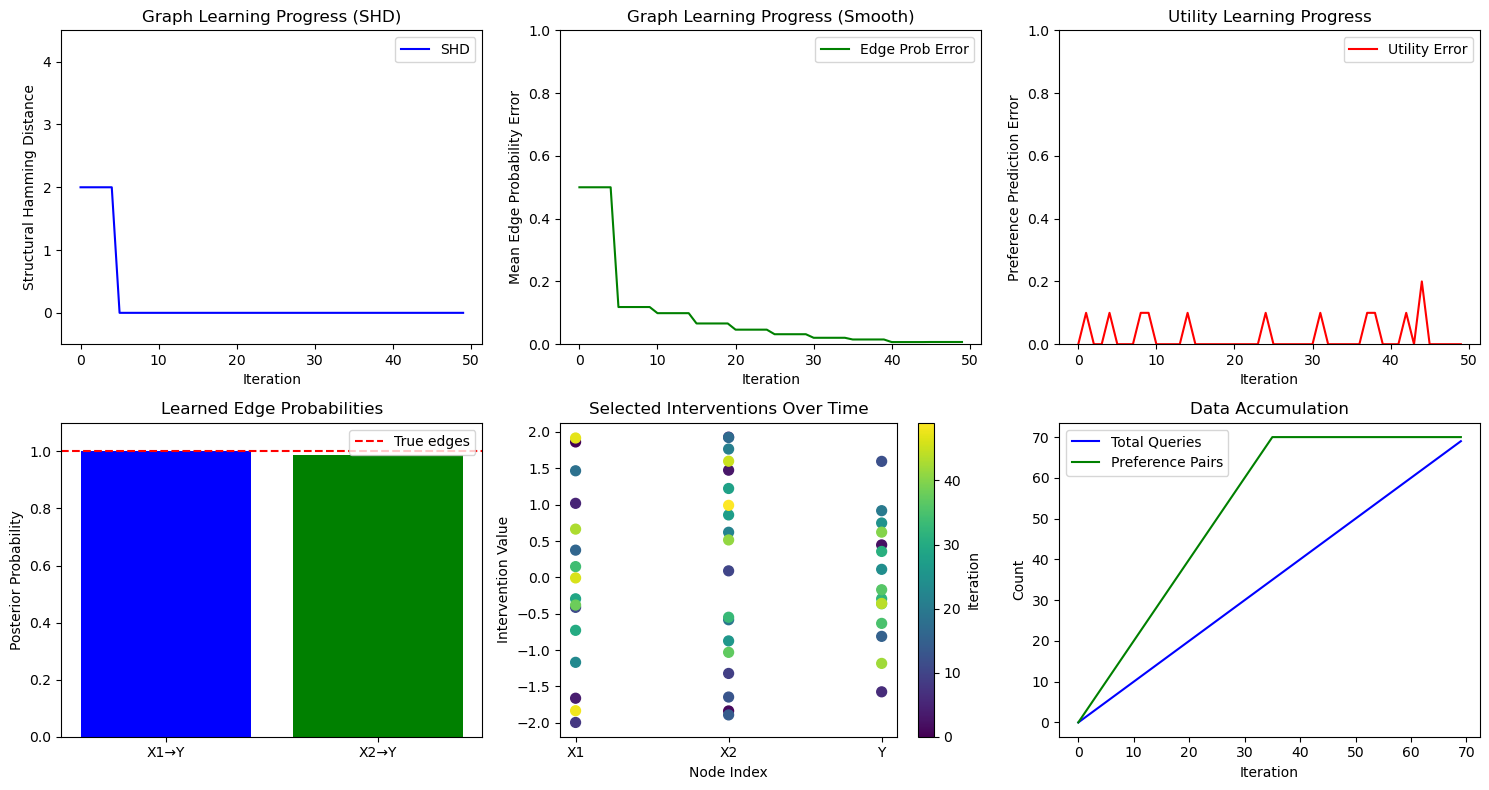

In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Graph Learning Progress (SHD)
axes[0, 0].plot(pcbo.iteration_history, pcbo.graph_distances, 'b-', label='SHD')
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Structural Hamming Distance")
axes[0, 0].set_title("Graph Learning Progress (SHD)")
axes[0, 0].set_ylim([-0.5, 4.5])
axes[0, 0].legend()

# 2. Edge Probability Error (Smoother metric)
axes[0, 1].plot(pcbo.iteration_history, pcbo.edge_prob_errors, 'g-', label='Edge Prob Error')
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Mean Edge Probability Error")
axes[0, 1].set_title("Graph Learning Progress (Smooth)")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

# 3. Utility Learning Progress
axes[0, 2].plot(pcbo.iteration_history, pcbo.utility_errors, 'r-', label='Utility Error')
axes[0, 2].set_xlabel("Iteration")
axes[0, 2].set_ylabel("Preference Prediction Error")
axes[0, 2].set_title("Utility Learning Progress")
axes[0, 2].set_ylim([0, 1])
axes[0, 2].legend()

# 4. Final Edge Probabilities
edge_probs = pcbo.parent_posterior.edge_posterior().numpy()
axes[1, 0].bar(['X1→Y', 'X2→Y'], edge_probs, color=['blue', 'green'])
axes[1, 0].axhline(y=1.0, color='r', linestyle='--', label='True edges')
axes[1, 0].set_ylabel("Posterior Probability")
axes[1, 0].set_title("Learned Edge Probabilities")
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].legend()

# 5. Selected Interventions Over Time
interventions_array = np.array(pcbo.selected_interventions)
scatter = axes[1, 1].scatter(interventions_array[:, 0], interventions_array[:, 1], 
                            c=range(len(interventions_array)), cmap='viridis', s=50)
axes[1, 1].set_xlabel("Node Index")
axes[1, 1].set_ylabel("Intervention Value")
axes[1, 1].set_title("Selected Interventions Over Time")
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['X1', 'X2', 'Y'])
plt.colorbar(scatter, ax=axes[1, 1], label='Iteration')

# 6. Preference Dataset Growth
axes[1, 2].plot(range(len(all_queries)), [i for i in range(len(all_queries))], 'b-', label='Total Queries')
axes[1, 2].plot(range(len(all_queries)), [min(i*2, len(pcbo.pref_dataset)) for i in range(len(all_queries))], 
               'g-', label='Preference Pairs')
axes[1, 2].set_xlabel("Iteration")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Data Accumulation")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## Final Results and Analysis


FINAL RESULTS

True causal graph:
[[0 0 1]
 [0 0 1]
 [0 0 0]]

Most probable parent set for Y: (1, 1)
Posterior probability: 0.986

Edge posterior probabilities:
  P(X1 → Y) = 1.000 (True: 1.0)
  P(X2 → Y) = 0.986 (True: 1.0)

Final metrics:
  SHD: 0.00
  Edge probability error: 0.007
  Utility prediction error: 0.000

Learning efficiency:
  Total queries: 70
  Total preference comparisons: 70
  Flow reinitializations: 0

Visualization of learned causal structure:


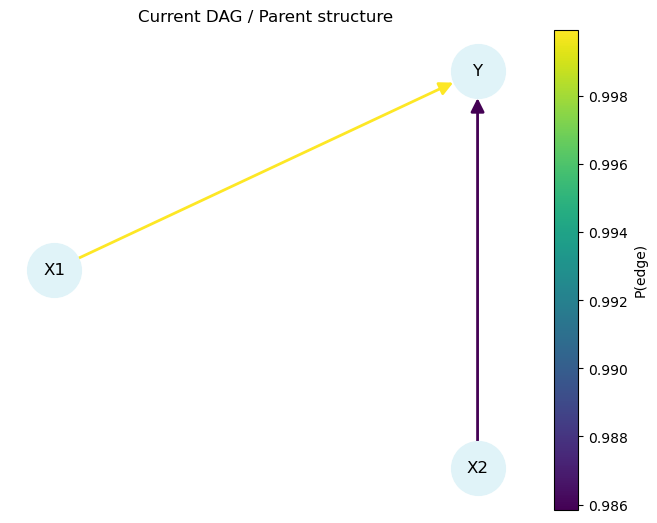


PCBO COMPLETE


In [7]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print(f"\nTrue causal graph:")
print(f"{true_adj.numpy()}")

most_prob_parents, prob = pcbo.parent_posterior.most_probable_set()
print(f"\nMost probable parent set for Y: {most_prob_parents}")
print(f"Posterior probability: {prob:.3f}")

edge_probs = pcbo.parent_posterior.edge_posterior()
print(f"\nEdge posterior probabilities:")
print(f"  P(X1 → Y) = {edge_probs[0]:.3f} (True: 1.0)")
print(f"  P(X2 → Y) = {edge_probs[1]:.3f} (True: 1.0)")

print(f"\nFinal metrics:")
print(f"  SHD: {pcbo.graph_distances[-1]:.2f}")
print(f"  Edge probability error: {pcbo.edge_prob_errors[-1]:.3f}")
print(f"  Utility prediction error: {pcbo.utility_errors[-1]:.3f}")

print(f"\nLearning efficiency:")
print(f"  Total queries: {len(all_queries)}")
print(f"  Total preference comparisons: {len(pcbo.pref_dataset)}")
print(f"  Flow reinitializations: {pcbo.reinitialization_count}")

# Visualize final learned causal structure
learned_adj = torch.zeros_like(true_adj)
for i, is_parent in enumerate(most_prob_parents):
    if is_parent:
        learned_adj[i, 2] = 1

print("\nVisualization of learned causal structure:")
plot_dag(learned_adj.numpy(), names=node_names, 
         edge_probs=torch.tensor([[0, 0, edge_probs[0]], 
                                  [0, 0, edge_probs[1]], 
                                  [0, 0, 0]]).numpy())

print("\n" + "="*50)
print("PCBO COMPLETE")
print("="*50)